In [1]:
from PIL import Image
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../') # add relative path

from module.sttr import STTR
from dataset.preprocess import normalization, compute_left_occ_region
from utilities.misc import NestedTensor

### Define STTR model

In [2]:
# Default parameters
args = type('', (), {})() # create empty args
args.channel_dim = 128
args.position_encoding='sine1d_rel'
args.num_attn_layers=6
args.nheads=4
args.regression_head='ot'
args.context_adjustment_layer='cal'
args.cal_num_blocks=8
args.cal_feat_dim=16
args.cal_expansion_ratio=4

In [3]:
model = STTR(args).cuda().eval()

In [4]:
# Load the pretrained model
model_file_name = "/home/guoweiyu/stereo-transformer/run/sceneflow/pretrain/experiment_1/epoch_17_model.pth.tar"
checkpoint = torch.load(model_file_name)
pretrained_dict = checkpoint['state_dict']
model.load_state_dict(pretrained_dict)
print("Pre-trained model successfully loaded.")

Pre-trained model successfully loaded.


### Read image

In [5]:
left = np.array(Image.open('/data/KITTI2015_1/training/image_2/000045_10.png'))
right = np.array(Image.open('/data/KITTI2015_1/training/image_3/000045_10.png'))
disp = np.array(Image.open('/data/KITTI2015_1/training/disp_occ_0/000045_10.png')).astype(np.float) / 256.

/tmp/ipykernel_29694/2683734245.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  disp = np.array(Image.open('/data/KITTI2015_1/training/disp_occ_0/000045_10.png')).astype(np.float) / 256.


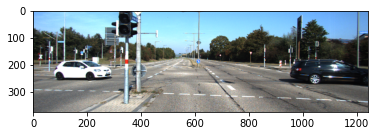

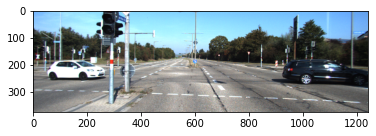

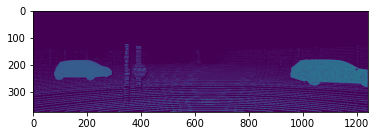

In [6]:
# Visualize image
plt.figure(1)
plt.imshow(left)
plt.figure(2)
plt.imshow(right)
plt.figure(3)
plt.imshow(disp)

Preprocess data for STTR

In [7]:
# normalize
input_data = {'left': left, 'right':right, 'disp':disp}
input_data = normalization(**input_data)

In [8]:
h, w, _ = left.shape

In [9]:
# build NestedTensor
input_data = NestedTensor(input_data['left'].cuda()[None,],input_data['right'].cuda()[None,])

### Inference

In [10]:
%%time
with torch.no_grad():
    output = model(input_data)
    torch.cuda.synchronize()

/home/guoweiyu/anaconda3/envs/sttr/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/home/guoweiyu/anaconda3/envs/sttr/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/guoweiyu/anaconda3/envs/sttr/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior 

CPU times: user 1.56 s, sys: 381 ms, total: 1.94 s
Wall time: 1.09 s


In [11]:
# set disparity of occ area to 0
disp_pred = output['disp_pred'].data.cpu().numpy()[0]
occ_pred = output['occ_pred'].data.cpu().numpy()[0] > 0.5
disp_pred[occ_pred] = 0.0

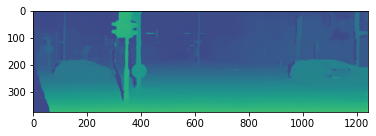

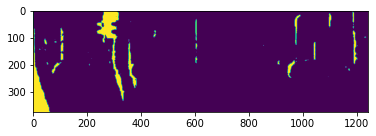

In [12]:
# visualize predicted disparity and occlusion map
plt.figure(4)
plt.imshow(disp_pred)
plt.figure(5)
plt.imshow(occ_pred)

### Compute metrics

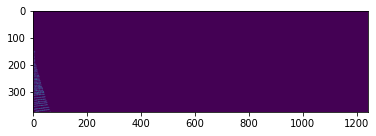

In [13]:
# manually compute occluded region
occ_mask = compute_left_occ_region(w, disp)

# visualize the known occluded region
plt.figure(6)
plt.imshow(occ_mask)

In [14]:
# compute difference in non-occluded region only
diff = disp - disp_pred
diff[occ_mask] = 0.0 # set occ area to be 0.0

# Note: code for computing the metrics can be found in module/loss.py
valid_mask = np.logical_and(disp > 0.0, ~occ_mask)

# find 3 px error
err_px = (diff > 3).sum()
total_px = (valid_mask).sum()
print('3 px error %.3f%%'%(err_px*100.0/total_px))

# find epe
err = np.abs(diff[valid_mask]).sum()
print('EPE %f'%(err * 1.0/ total_px))

3 px error 10.451%
EPE 1.812204
